### The objective of this prediction task is to predict 3 months of item-level sales data at different store locations using deep learning techniques



In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU, Dropout, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

import numpy as np   

import os 
import warnings
import datetime as dt


# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)

# Data Set Description

Fields
* date - Date of the sale data. There are no holiday effects or store closures.

* store - Store ID

* item - Item ID

* sales - Number of items sold at a particular store on a particular date.


# Reading and Preparing the Data
Let's start by preparing our data. We will store it in a dataframe. We are only interested in the sales number.

In [10]:
file_name = 'train.csv'
dataset = pd.read_csv(file_name, parse_dates=['date'])

dataset.drop(labels=['store', 'item'], axis=1, inplace = True)

In [13]:
dataset.dtypes

date     datetime64[ns]
sales             int64
dtype: object

In [11]:
dataset.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [12]:
dataset.describe()

,sales
count,913000.000000
mean,52.250287
std,28.801144
min,0.000000
25%,30.000000
50%,47.000000
75%,70.000000
max,231.000000


In [14]:
# split a univariate sequence into samples
def split_sequence(data, days_past, days_future):
    X, y = list(), list()
    
    for i in range(len(data)):        
        # find the end of this pattern
        end_ix = i + days_past
        out_end_ix = end_ix + days_future
        
        # check if we are beyond the sequence
        if out_end_ix > len(data):
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix], data[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

# Time period of the dataset
Let's see what is the start and end of the dataset

In [15]:
print('Min date from train set: %s' % dataset.date.min().date())
print('Max date from train set: %s' % dataset.date.max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


# Checking for NaN (missing values) in the dataframe
There is multiple ways of doing this, I have chosen do it with the following method:

In [16]:
dataset.sales.isnull().sum()

0

This dataset is pretty easy, no missing data... less work for us :)

# Splitting the data set in training and test sets
This part is important since we will be using the training set to train the model and the test set to check if the model does well on unseen inputs.

We are going to use only a small subset of the data due to training time. In competitons, use as much data that there is avaialable to botrain a stronger model that is good at generalizing. 

In [17]:
training_data = dataset[(dataset['date'] <= '2016')]
test_data = dataset[(dataset['date'] >= '2017')]

training_data.sort_values('date', inplace=True)
training_data = training_data.groupby('date')
training_data = training_data.agg({'sales':'mean'})
training_data.colums = ['sales']

test_data.sort_values('date', inplace=True)
test_data = test_data.groupby('date')
test_data = test_data.agg({'sales':'mean'})
test_data.colums = ['sales']

print(len(training_data))
print(len(test_data))

1096
365


In [18]:
training_data.head()

,sales
date,
2013-01-01,27.392
2013-01-02,27.356
2013-01-03,28.976
2013-01-04,31.354
2013-01-05,32.474


# Visualizing and Plotting our Data
It is very important to plot and visualize the data to get a good grasp of what is happening. For this, I have decided to use plotly, but you can use any other visualizaiton library such as seaborn and matplotlib. We are using plotly graph objects since we will need to create subplots later.

In [19]:
fig  = make_subplots()
fig.add_trace(go.Scatter(x=training_data.index,y=training_data.sales,name="Zoom"))
fig.update_layout(autosize=True,width=900,height=500,title_text="Sales")
fig.update_xaxes(title_text="year")
fig.update_yaxes(title_text="prices")
fig.show()

Now to plot the training and test data on the same plot. Notice the lag between the training data and test data. This is done on purpose to ensure that the test data isn't too strongly correlated to the training data.

In [20]:
fig  = make_subplots()
fig.add_trace(go.Scatter(x=training_data.index,y=training_data.sales,name="Train"))
fig.add_trace(go.Scatter(x=test_data.index,y=test_data.sales,name="Test"))
fig.update_layout(autosize=False,width=900,height=500,title_text="Sales")
fig.update_xaxes(title_text="day")
fig.update_yaxes(title_text="prices")
fig.show()

# Scaling the training data
Here we will use MinMaxScaler from the Sci-kit learn library to standardize and scale our input data between 0-1.

In [21]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_tain_data = scaler.fit_transform(training_data.values.reshape(-1,1))
scaled_tain_data.shape

(1096, 1)

In [22]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_test_data = scaler.fit_transform(test_data.values.reshape(-1,1))
scaled_test_data.shape

(365, 1)

# Transforming the data into a time-series appropriate problem
We will now have to rpepare the data in a form that is appropriate to be fed into a RNN/LSTM network. The key is to seperate the data into past sequence (Day 0-29) that is going to be used to predict the future sequence (Day 30-34) for example.

In [23]:
days_past = 30   # use past 30 time steps to predict
days_future = 5  # predict 5 time steps in the future

x_train, y_train = split_sequence(scaled_tain_data, days_past, days_future)
x_test, y_test = split_sequence(scaled_test_data, days_past, days_future)

In [24]:
print(x_train.shape)
print(x_test.shape)

(1062, 30, 1)
(331, 30, 1)


The  model expects the input to have shape: (Samples, Timesteps, Number of feautures). 

In [25]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))

x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

In [26]:
print(x_train.shape)
print(x_test.shape)

(1062, 30, 1)
(331, 30, 1)


# Model 1 :  RNN
We are going to be creating a three layer RNN Network with a dense layer at the end. We are using dropout as a regularisation method to combat overffiting.


In [52]:
def rnn_model():
    

    
    # Use Keras sequential model
    model = Sequential()
    
    model.add(LSTM(units = 100, return_sequences = True, input_shape  = (days_past,1)))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
              
    model.add(LSTM(units = 50, return_sequences = False))
    model.add(Dropout(0.2))
              
    model.add(Dense(units=1, activation = "linear"))
    
    return model

In [53]:
rnn_model = rnn_model()
rnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 100)           40800     
                                                                 
 dropout_12 (Dropout)        (None, 30, 100)           0         
                                                                 
 lstm_13 (LSTM)              (None, 30, 50)            30200     
                                                                 
 dropout_13 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_14 (Dropout)        (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [56]:
rnn_model.compile(optimizer = 'adam', loss = 'mean_squared_error')



In [57]:
history=rnn_model.fit(x_train,y_train,epochs=20, validation_data = [x_test, y_test],verbose=1)

Epoch 1/20
34/34 [==============================] - 5s 56ms/step - loss: 0.0166 - val_loss: 0.0198
Epoch 2/20
34/34 [==============================] - 1s 32ms/step - loss: 0.0161 - val_loss: 0.0216
Epoch 3/20
34/34 [==============================] - 1s 34ms/step - loss: 0.0162 - val_loss: 0.0196
Epoch 4/20
34/34 [==============================] - 1s 32ms/step - loss: 0.0155 - val_loss: 0.0203
Epoch 5/20
34/34 [==============================] - 1s 32ms/step - loss: 0.0156 - val_loss: 0.0224
Epoch 6/20
34/34 [==============================] - 1s 32ms/step - loss: 0.0158 - val_loss: 0.0191
Epoch 7/20
34/34 [==============================] - 1s 32ms/step - loss: 0.0156 - val_loss: 0.0210
Epoch 8/20
34/34 [==============================] - 1s 33ms/step - loss: 0.0156 - val_loss: 0.0190
Epoch 9/20
34/34 [==============================] - 1s 32ms/step - loss: 0.0151 - val_loss: 0.0190
Epoch 10/20
34/34 [==============================] - 1s 32ms/step - loss: 0.0150 - val_loss: 0.0189
Epoch 11/

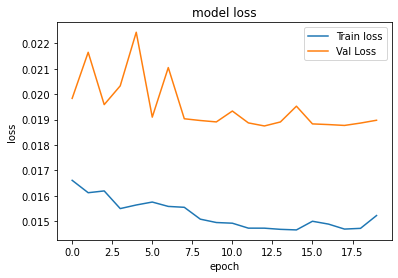

In [58]:
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = "Val Loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Model 2 :  LSTM Network
We are going to be creating a three layer LSTM Network with a dense layer at the end. We are using dropout as a regularisation method to combat overffiting.

In [60]:
def encoder_decoder_model():
    
    # Use Keras sequential model
    model = Sequential()
    
    # Encoder LSTM layer with Dropout regularisation; Set return_sequences to False since we are feeding last output to decoder layer
    model.add(LSTM(100, activation='relu',input_shape = (days_past,1)))
    model.add(Dropout(0.2))
    
    # The fixed-length output of the encoder is repeated, once for each required time step in the output sequence with the RepeatVector wrapper
    model.add(RepeatVector(days_future))
    
    # Decoder LSTM layer with Dropout regularisation; Set return_sequences to True to feed each output time step to a Dense layer
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    
    # Same dense layer is repeated for each output timestep with the TimeDistributed wrapper
    model.add(TimeDistributed(Dense(units=1, activation = "linear")))
    
    return model

In [61]:
LSTM_model = encoder_decoder_model()
LSTM_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 100)               40800     
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 5, 100)           0         
 )                                                               
                                                                 
 lstm_16 (LSTM)              (None, 5, 100)            80400     
                                                                 
 dropout_16 (Dropout)        (None, 5, 100)            0         
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 1)             101       
 tributed)                                            

Now we set our compiler and our optimatization mechanism. We will be using the Adam optimazation method since it is widely used and performs much better than regular gradient descent.

In [62]:
LSTM_model.compile(optimizer='adam', loss='mean_squared_error')


We can finally train our model with our training data. Let's see how it does.

In [64]:
history=LSTM_model.fit(x_train,y_train,epochs=20, validation_data = [x_test, y_test],verbose=1)

Epoch 1/20
34/34 [==============================] - 1s 21ms/step - loss: 0.0166 - val_loss: 0.0204
Epoch 2/20
34/34 [==============================] - 1s 15ms/step - loss: 0.0164 - val_loss: 0.0209
Epoch 3/20
34/34 [==============================] - 1s 15ms/step - loss: 0.0167 - val_loss: 0.0201
Epoch 4/20
34/34 [==============================] - 1s 15ms/step - loss: 0.0165 - val_loss: 0.0206
Epoch 5/20
34/34 [==============================] - 1s 15ms/step - loss: 0.0164 - val_loss: 0.0199
Epoch 6/20
34/34 [==============================] - 1s 15ms/step - loss: 0.0163 - val_loss: 0.0213
Epoch 7/20
34/34 [==============================] - 1s 16ms/step - loss: 0.0164 - val_loss: 0.0214
Epoch 8/20
34/34 [==============================] - 1s 15ms/step - loss: 0.0159 - val_loss: 0.0199
Epoch 9/20
34/34 [==============================] - 1s 15ms/step - loss: 0.0164 - val_loss: 0.0199
Epoch 10/20
34/34 [==============================] - 1s 16ms/step - loss: 0.0162 - val_loss: 0.0198
Epoch 11/

Let us now visualize the loss and accuracy to see how the training went.

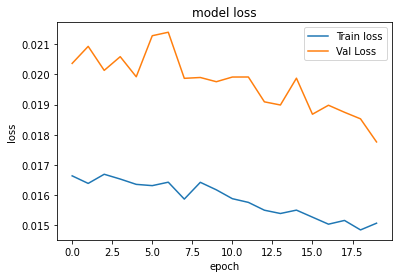

In [65]:
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = "Val Loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

We see that the loss decreaes and is lower than 0.2 MSE. This shows that our model is indeed doing well on the training data.

# Model 3 :  GRU Network
We are going to be creating a three layer GRU Network with a dense layer at the end. We are using dropout as a regularisation method to combat overffiting.

In [77]:
def gru_model():
    
    # Use Keras sequential model
    model = Sequential()
    
    # Encoder GRU layer with Dropout regularisation; Set return_sequences to False since we are feeding last output to decoder layer
    model.add(GRU(100, activation='relu',input_shape = (days_past,1)))
    model.add(Dropout(0.2))
    
    # The fixed-length output of the encoder is repeated, once for each required time step in the output sequence with the RepeatVector wrapper
    model.add(RepeatVector(days_future))
    
    # Decoder GRU layer with Dropout regularisation; Set return_sequences to True to feed each output time step to a Dense layer
    model.add(GRU(100, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    
    # Same dense layer is repeated for each output timestep with the TimeDistributed wrapper
    model.add(TimeDistributed(Dense(units=1, activation = "linear")))
    
    return model

In [78]:
GRU_model = gru_model()
GRU_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 100)               30900     
                                                                 
 dropout_19 (Dropout)        (None, 100)               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 5, 100)           0         
 or)                                                             
                                                                 
 gru_3 (GRU)                 (None, 5, 100)            60600     
                                                                 
 dropout_20 (Dropout)        (None, 5, 100)            0         
                                                                 
 time_distributed_3 (TimeDis  (None, 5, 1)             101       
 tributed)                                            

In [79]:
GRU_model.compile(optimizer='adam', loss='mean_squared_error')

In [80]:
history=GRU_model.fit(x_train,y_train,epochs=20, validation_data = [x_test, y_test],verbose=1)

Epoch 1/20
34/34 [==============================] - 2s 20ms/step - loss: 0.0664 - val_loss: 3774.7139
Epoch 2/20
34/34 [==============================] - 0s 14ms/step - loss: 0.0274 - val_loss: 3770.8088
Epoch 3/20
34/34 [==============================] - 0s 14ms/step - loss: 0.0199 - val_loss: 3768.2761
Epoch 4/20
34/34 [==============================] - 0s 14ms/step - loss: 0.0186 - val_loss: 3765.8003
Epoch 5/20
34/34 [==============================] - 0s 14ms/step - loss: 0.0185 - val_loss: 3767.6096
Epoch 6/20
34/34 [==============================] - 1s 15ms/step - loss: 0.0182 - val_loss: 3767.5647
Epoch 7/20
34/34 [==============================] - 1s 15ms/step - loss: 0.0177 - val_loss: 3769.2820
Epoch 8/20
34/34 [==============================] - 1s 15ms/step - loss: 0.0176 - val_loss: 3765.4592
Epoch 9/20
34/34 [==============================] - 0s 14ms/step - loss: 0.0170 - val_loss: 3766.6597
Epoch 10/20
34/34 [==============================] - 0s 14ms/step - loss: 0.0173 -

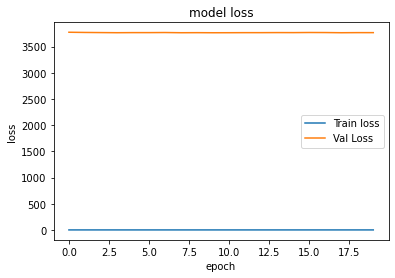

In [81]:
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = "Val Loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Key Findings
In this task, I have used 3 deep neural network architectures to predict the time series data. These models are RNN, LSTM, and GRU. LSTM has performed better than GRU and RNN with MSE less than 0.15

# Next Steps

In the future, some extra hyperparamters tunning can be performed to improve the accuracy of models. such as using diffrent oprtimiers and learning rates. Also some different neural network can be tried with diffrent number of layers to come up with better model.